In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Устанавливаем случайное зерно для воспроизводимости
np.random.seed(42)

In [3]:
df = pd.read_csv('bank-full.csv', sep=';')
print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns]


df_train, df_temp = train_test_split(df, test_size=0.25, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)


print(f'Обучающая выборка: {df_train.shape}')
print(f'Валидационная выборка: {df_val.shape}')
print(f'Тестовая выборка: {df_test.shape}')

Обучающая выборка: (33908, 17)
Валидационная выборка: (5651, 17)
Тестовая выборка: (5652, 17)


In [18]:
from sklearn.metrics import roc_auc_score


numeric_columns = ['balance', 'day', 'duration', 'campaign']
auc_scores = {}


for column in numeric_columns:
    auc = roc_auc_score(df_train['y'], df_train[column])
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[column])
    auc_scores[column] = auc
print('AUC для каждого признака', auc_scores)

AUC для каждого признака {'balance': 0.5925039928796861, 'day': 0.5271368188970291, 'duration': 0.8117171432689722, 'campaign': 0.5747113529307714}


In [21]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

y_train = df_train['y'].values
y_val = df_val['y'].values


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# AUC на валидационной выборке
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC на валидационной выборке: {auc:.3f}")

AUC на валидационной выборке: 1.000


In [22]:
df_train['y'] = df_train['y'].apply(lambda x: 1 if x == 'yes' else 0)
df_val['y'] = df_val['y'].apply(lambda x: 1 if x == 'yes' else 0)
y_train = df_train['y'].values
y_val = df_val['y'].values

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


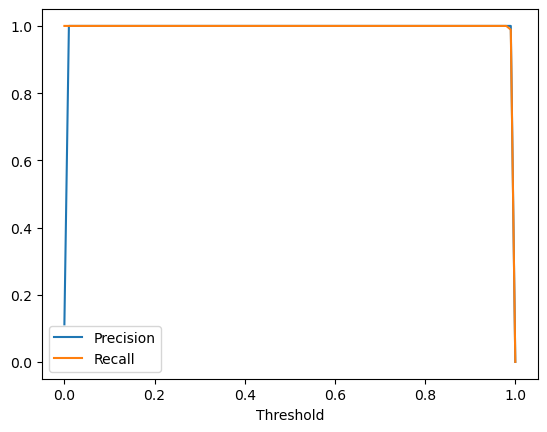

Порог, на котором пересекаются Precision и Recall: 0.01


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    precision_scores.append(precision_score(y_val, y_pred_threshold))
    recall_scores.append(recall_score(y_val, y_pred_threshold))

plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

# Найдем порог пересечения
crossing_threshold = thresholds[np.argmin(np.abs(np.array(precision_scores) - np.array(recall_scores)))]
print(f"Порог, на котором пересекаются Precision и Recall: {crossing_threshold}")

In [24]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(y_val, (y_pred >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Максимум F1 score достигается при пороге: {best_threshold}")

Максимум F1 score достигается при пороге: 0.01


In [25]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.000001, 0.001, 1]
best_C = None
best_mean_auc = 0

for C in C_values:
    aucs = []
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    for train_idx, val_idx in kf.split(df_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred_fold = model.predict_proba(X_fold_val)[:, 1]
        aucs.append(roc_auc_score(y_fold_val, y_pred_fold))
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    print(f"C={C} - Средний AUC: {mean_auc:.3f}, Стандартное отклонение: {std_auc:.3f}")
    
    if mean_auc > best_mean_auc:
        best_C = C
        best_mean_auc = mean_auc

print(f"Лучшее значение C: {best_C}")

C=1e-06 - Средний AUC: 0.702, Стандартное отклонение: 0.010
C=0.001 - Средний AUC: 0.998, Стандартное отклонение: 0.001
C=1 - Средний AUC: 1.000, Стандартное отклонение: 0.000
Лучшее значение C: 1


1. Ответ: duration
2. Ответ: 1.000
3. Ответ: 0.01
4. Ответ: 0.01
5. Ответ: для C = 10^-6 - ошибка = 0.010, для C = 10^-3 - ошибка = 0.001, для C = 1, ошибка = 0
6. Ответ: при С = 1.